Seojin

# Notice

You can visualize plot only in mac. I tested vedo in Ubuntu, but It did not work.

# Vedo(Visualization of эD Objects)

Vedo is scientific tool for visualizing 3d objects

Official site: https://vedo.embl.es  
Github: https://github.com/marcomusy/vedo/tree/master/examples/notebooks

# Mesh

For visualizing 3d Object, You should make mesh(vertexes) based on nifti image. For making vtk file, I used nii2mesh.

Github: https://github.com/neurolabusc/nii2mesh

ex) nii2mesh lt_hippo_fan.nii lt_hippo_fan_d.vtk

# Library

In [1]:
import nibabel as nb
import vedo
from matplotlib import cm
import matplotlib.pylab as plt
import numpy as np
import os
from matplotlib.colors import to_hex
from vedo import Text2D, Sphere, Plotter
import glob
from pathlib import Path
from skimage import io

import sys
sys.path.append("../")

# Custom Libraries
from afni_extension import set_afni_abin, cluster_infos, clusterize, find_thresholds_1samp
from sj_brain_vis import cluster_to_mesh, make_mesh_fromRM, make_cluster_spheres, make_cluster_meshes
from sj_higher_function import flatten

set_afni_abin("/Users/clmn/abin/afni")

# Input

In [22]:
model_dir_path = "/Users/clmn/Downloads/vedo_vis/statmap/model"

is_paired_test = True
model_param = "st_c" # st_r ts_c ts_r

if is_paired_test:
    stat_map_paths = sorted(glob.glob(os.path.join(model_dir_path, model_param, "*paired*")))
else:
    stat_map_paths = sorted(glob.glob(os.path.join(model_dir_path, model_param, "*1samp*")))

if model_param.startswith("st"):
    pass
else:
    stat_map_paths = stat_map_paths[4:] + stat_map_paths[:4]
    
file_names = [Path(path).stem for path in stat_map_paths]

# Params

In [23]:
# Directory path for saving cluster result
cluster_dir_path = "/Users/clmn/Downloads/vedo_vis/brain_rois/clusters"

# Base brain mask - LPS+ coords(mni, spm)
base_brain_nii_path = "/Users/clmn/Downloads/vedo_dir/group_mask.nii"

# Brain roi path
brain_roi_path = "/Users/clmn/Downloads/vedo_vis/brain_rois"

# Plotting method
cluster_plot_style = "mesh" # mesh, point

# Clusterize params
atlas_query_method = "center"
n_datas = np.repeat(20, len(stat_map_paths))
thresholds = None
candidate_p_values = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
cluster_size = 40
criteria_n_cluster = 6
NN_level = 1


# Calculate optimizing threshold

In [24]:
if thresholds == None:
    # Make thresholds
    clust_infos = []
    for path, n_data in zip(stat_map_paths, n_datas):
        clust_info = find_thresholds_1samp(stat_path = path, 
                                           candidate_p_values = candidate_p_values,
                                           criteria_n_cluster = criteria_n_cluster, 
                                           n_data = n_data, 
                                           cluster_size = cluster_size,
                                           NN_level = NN_level)
        clust_infos.append(clust_info)
    
    thresholds = [info["t_thres"] for info in clust_infos]

# Base brain

In [5]:
# Load base brain
base_brain_vtk_path = os.path.join(cluster_dir_path, f"{Path(base_brain_nii_path).stem}.vtk")
os.system(f"nii2mesh {base_brain_nii_path} {base_brain_vtk_path}")

base_brain_vtk_volume = vedo.load(base_brain_vtk_path).opacity(0.1)

# Get cluster information

In [26]:
if cluster_plot_style == "mesh":
    # Remove files if cluster mask exists
    clust_mask_paths = glob.glob(os.path.join(cluster_dir_path, "*_clust_mask.nii"))
    for path in clust_mask_paths:
        os.system(f"rm {path}")
    
    # File path of cluster mask
    pref_maps = []
    for file_path in stat_map_paths:
        path = os.path.join(cluster_dir_path, file_path.split(os.sep)[-1].split(".")[0] + "_clust_mask.nii")
        pref_maps.append(path)
else:
    pref_maps = None

# query based on spm coordinate
cluster_dfs = cluster_infos(stat_map_paths = stat_map_paths,
                            thresholds = thresholds,
                            cluster_sizes = np.repeat(cluster_size, len(stat_map_paths)),
                            is_positive = True,
                            pref_maps = pref_maps,
                            atlas_query_method = atlas_query_method,
                            NN_level = NN_level)


In [27]:
# Make cluster vtk files
if cluster_plot_style == "mesh":
    cluster_mesh_paths = []
    for model_i, path in enumerate(pref_maps):
        if type(cluster_dfs[model_i]) == type(None):
            cluster_mesh_paths.append([])
            continue

        cluster_numbers = cluster_dfs[model_i].index + 1
        paths = cluster_to_mesh(cluster_map_path = pref_maps[model_i], 
                                cluster_numbers = cluster_numbers, 
                                save_dir_path = cluster_dir_path)
        cluster_mesh_paths.append(paths)

# ROI

In [82]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(roi_vtk_files)))
colors = colors[::-1]
colors = [to_hex(color) for color in colors]

In [83]:
# ROI vtks
roi_vtk_files = glob.glob(os.path.join(brain_roi_path, "*.vtk"))

# ROI volumes
roi_vtk_volumes = []
for vtk_path, color in zip(roi_vtk_files, colors):
    roi_vtk_volume = vedo.load(vtk_path)
    
    roi_vtk_volume = roi_vtk_volume
    roi_vtk_volume = roi_vtk_volume.opacity(0.3)
    roi_vtk_volume = roi_vtk_volume.color(color)
    roi_vtk_volume = roi_vtk_volume.lighting('glossy')
    roi_vtk_volumes.append(roi_vtk_volume)
    

/Users/clmn/Downloads/vedo_vis/brain_rois/Rt_orbital.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Lt_red_nucleus.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Lt_medioventral_occipital.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Rt_cingulate.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Rt_paracentral.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Rt_superior_frontal_gyrus.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Lt_superior_parietal.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Lt_orbital.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Rt_thalamus.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Rt_red_nucleus.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Lt_fusiform.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Lt_inferior_parietal.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Rt_parahippocampal.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Lt_substantia_nigra.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Lt_basal_ganglia.vtk
/Users/clmn/Downloads/vedo_vis/brain_rois/Rt_amygdala.vt

# Clusters

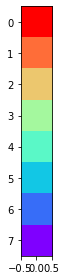

In [85]:
# cluster color
colors = plt.cm.rainbow(np.linspace(0, 1, len(cluster_dfs)))
colors = colors[::-1]
io.imshow(np.expand_dims(colors[:,:-1], 1))

colors = [to_hex(color) for color in colors]

# stack result
clusters = []

if cluster_plot_style == "point":
    for cluster_df, color in zip(cluster_dfs, colors):
        l_clusters = make_cluster_spheres(cluster_df = cluster_df, color = color)
        clusters.append(l_clusters)
else:
    for cluster_df, mesh_paths, color in zip(cluster_dfs, cluster_mesh_paths, colors):
        l_clusters = make_cluster_meshes(cluster_df = cluster_df, mesh_paths = mesh_paths, color = color)
        clusters.append(l_clusters)

for c in flatten(clusters):
    c.opacity(1.0)

# Merge drawings

In [86]:
base_brain_volume = base_brain_vtk_volume.opacity(0)

In [87]:
def func(evt):
    if not evt.actor:
        return
    try:
        origin = evt.actor.c()
        # sil = evt.actor.c('red5')
        msg.text("area name: "+ evt.actor.name)
        # plt.remove('silu').add(sil)
    except:
        pass


In [88]:
def show_clusters(clusters, opacity):
    for c in clusters:
        c.opacity(opacity)

In [89]:
msg = Text2D("", pos="bottom-center", c='k', bg='r9', alpha=0.8)

plotter = Plotter(axes=1, bg='black')
plotter.addCallback('mouse click', func)

slider_info = {
    "current" : 0
}

xmin = 0
xmax = 8

x_indexes = np.arange(len(stat_map_paths))

def slider(widget, event):    
    maximum = widget.GetSliderRepresentation().GetMaximumValue()
    v = widget.GetSliderRepresentation().GetCurrentT()
    
    current_range = int(np.round((v * maximum), 0))
    
    if slider_info["current"] == current_range:
        pass
    else:
        slider_info["current"] = current_range
        
        if current_range == 0:
            msg.text("show All")
            
            # All clusters
            for x_i in x_indexes:
                show_clusters(clusters = clusters[x_i], opacity = 1.0)
        else:
            # if 1, show 0 index stat cluster
            x_i = current_range - 1
            
            msg.text(f"show {file_names[x_i]}")

            other_indexes = x_indexes[x_indexes != x_i]
            for i in other_indexes:
                show_clusters(clusters = clusters[i], opacity = 0.0)
                
            show_clusters(clusters = clusters[x_i], opacity = 1.0)

plotter.addSlider2D(
    sliderfunc = slider,
    xmin = xmin,
    xmax = xmax,
    value = 0,
    c = "blue",
    pos = "bottom-right-vertical",
    title = "alpha value (opacity)"
)

plotter.show(clusters + roi_vtk_volumes + [base_brain_volume], 
         msg,
         __doc__, 
         axes = 2,
         zoom=1.2)
plotter.close()